In [1]:
#Нейро-нечеткие системы
#Лабораторная работа №4

#Задача: классификация текстов

In [14]:
#мешок слов

%matplotlib inline
import os

from ipywidgets import Select, SelectMultiple, interactive,  Layout, Box, Label

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
import sklearn.metrics as metrics

import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
from sklearn.model_selection import train_test_split
import sklearn.feature_selection 
import nltk
#перед использованием раскомментировать
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mkhitaryanvictoria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mkhitaryanvictoria/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# !pip3 install gensim==3.4.0
# !pip3 install smart_open==1.9.0
# import gensim

In [16]:
#оригинальный датасет
df = pd.read_csv("doctor-who.csv", delimiter=",")
# df = df.select_dtypes(include=['number'])
df = df.fillna(0)
df.head(10)

,idx,text,type,details,episodeid,doctorid
0,0,Sylvest home,location,0,21-7,6
1,1,Twin boys are playing a cross between chess an...,context,0,21-7,6
2,2,Where's mother?,talk,REMUS,21-7,6
3,3,She's busy.,talk,SYLVEST,21-7,6
4,4,Does that mean she isn't talking to us?,talk,ROMULUS,21-7,6
5,5,"No, she's just busy.",talk,SYLVEST,21-7,6
6,6,We would like to see her.,talk,BOTH,21-7,6
7,7,She isn't here.,talk,SYLVEST,21-7,6
8,8,She's gone out without saying goodbye?,talk,REMUS,21-7,6
9,9,"Well, yes.",talk,SYLVEST,21-7,6


In [17]:
#выбрать столбец, который будет отвечать за тип
yselect = Select(
        options=list(df.columns),
        value=list(df.columns)[0],
        description='Select file:',
        disabled=False
    )
yselect

Select(description='Select file:', options=('idx', 'text', 'type', 'details', 'episodeid', 'doctorid'), value=…

In [18]:
#выбрать столбец, который будет отвечать за текст
xselect = Select(
        options=list(df.columns),
        value=list(df.columns)[0],
        description='Select file:',
        disabled=False
    )
xselect

Select(description='Select file:', options=('idx', 'text', 'type', 'details', 'episodeid', 'doctorid'), value=…

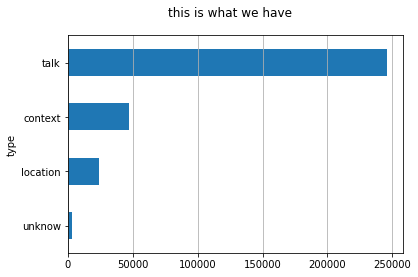

In [19]:
#просто смотрим какие у нас есть лейблы
fig, ax = plt.subplots()
fig.suptitle("this is what we have", fontsize=12)
df[yselect.value].reset_index().groupby(yselect.value).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [20]:
#препроцессинг
def preproc(text):
    #убираем пунктуацию
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    #токенизируем
    lst_text = text.split()
    
    #убираем стоп-слова
    stop_words = nltk.corpus.stopwords.words("english")
    lst_text = [word for word in lst_text if word not in 
                    stop_words]
                
    #стемминг
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]
                
    #лемматизация
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
            
    #конец обработки
    text = " ".join(lst_text)
    return text

In [21]:
df["text_clean"] = df[xselect.value].apply(lambda x: preproc(x))
df["text_clean"].head(10)

0                                         sylvest home
1    twin boy play cross chess andbackgammon larg p...
2                                         where mother
3                                             she busi
4                                     mean isnt talk u
5                                             she busi
6                                       would like see
7                                                 isnt
8                          she gone without say goodby
9                                              well ye
Name: text_clean, dtype: object

In [24]:
x = df["text_clean"].copy()
y = df[yselect.value].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [25]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

In [26]:
corpus = x_train
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [27]:
dic_vocabulary

{'report': 6765,
 'central': 1055,
 'control': 1441,
 'central control': 1057,
 'im': 3987,
 'sorri': 7645,
 'sabetha': 7019,
 'im sorri': 4042,
 'sure': 7983,
 'weve': 9462,
 'come': 1272,
 'right': 6832,
 'place': 6276,
 'weve come': 9463,
 'come right': 1315,
 'right place': 6868,
 'doctor': 1944,
 'tardi': 8112,
 'piec': 6252,
 'equip': 2539,
 'teeth': 8152,
 'doctor come': 1965,
 'come tardi': 1326,
 'piec equip': 6253,
 'doctor come tardi': 1967,
 'see': 7189,
 'sign': 7424,
 'kari': 4419,
 'look': 4902,
 'bundl': 867,
 'sever': 7298,
 'wire': 9578,
 'get': 3078,
 'intellig': 4168,
 'anticip': 286,
 'shall': 7312,
 'area': 338,
 'romana': 6931,
 'goe': 3290,
 'goe control': 3295,
 'twenti': 8891,
 'spacetim': 7684,
 'vortex': 9129,
 'timeand': 8652,
 'distanc': 1924,
 'mean': 5199,
 'littl': 4849,
 'room': 6941,
 'spacetim vortex': 7685,
 'moment': 5400,
 'open': 6004,
 'eye': 2675,
 'open eye': 6009,
 'ye': 9734,
 'say': 7095,
 'naughti': 5572,
 'friend': 2978,
 'kill': 4475,
 '

Text(0.5, 1.0, 'Sparse Matrix Sample')

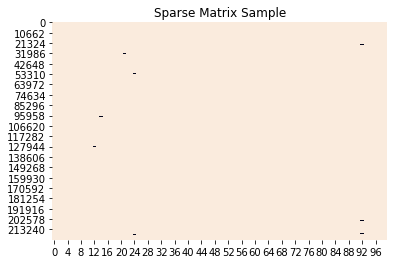

In [28]:
#карта слов
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [30]:
#попытка уменьшить плотность матрицы
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95 # довертельный интервал
dtf_features = pd.DataFrame()
for cat in np.unique(y_train):
    chi2, p = feature_selection.chi2(X_train, y_train==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")
    
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

# context:
  . selected features: 2876
  . top features: ace,across,adjust,adric,ah,aim,alarm,alcov,along,ami
 
# location:
  . selected features: 1760
  . top features: away,back,cant,could,cours,doctor,dont,go,good,got
 
# talk:
  . selected features: 3267
  . top features: ace,across,ah,alarm,alcov,ami,appear,approach,arm,around
 
# unknow:
  . selected features: 398
  . top features: dematerialis,krarg,meanwhil,two,wire,skagra,directli,vat,episod,salyavin
 


In [31]:
classifier = naive_bayes.MultinomialNB()
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
model["classifier"].fit(X_train, y_train)

X_test = x_test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)
                                

In [32]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("По классам:")
print(metrics.classification_report(y_test, predicted))
    

Accuracy: 0.92
По классам:
              precision    recall  f1-score   support

     context       0.86      0.74      0.79     13730
    location       0.93      0.79      0.85      7337
        talk       0.93      0.98      0.95     73835
      unknow       0.99      0.09      0.16      1053

    accuracy                           0.92     95955
   macro avg       0.93      0.65      0.69     95955
weighted avg       0.92      0.92      0.92     95955



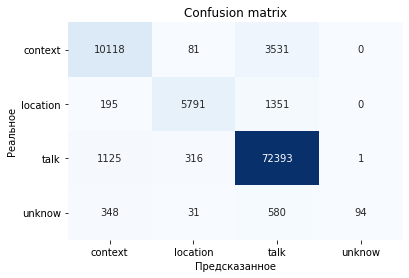

In [33]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Предсказанное", ylabel="Реальное", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

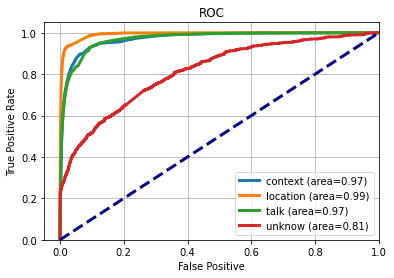

In [34]:
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax.plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive', 
          ylabel="True Positive Rate", 
          title="ROC")
ax.legend(loc="lower right")
ax.grid(True)
plt.show()

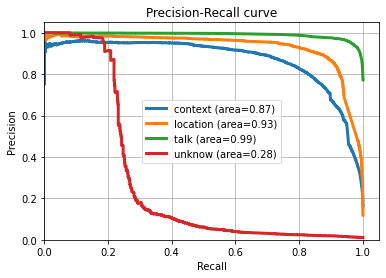

In [35]:
fig, ax = plt.subplots()
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax.plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax.set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax.legend(loc="best")
ax.grid(True)
plt.show()